In [1]:
NOTEBOOK_NAME = "sample_baseline_catboost_pandas"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib

from catboost import Pool
from catboost import CatBoostClassifier

In [3]:
train = pd.read_csv("../sample_data/train.csv")
test = pd.read_csv("../sample_data/test.csv")
sample_submission = pd.read_csv("../sample_data/gender_submission.csv")

# データ型の変更

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
categorical_cols = ["Sex", "Ticket", "Cabin", "Embarked"]

In [6]:
from sklearn.preprocessing import LabelEncoder


def label_encoder(train: pd.Series, test: pd.Series) -> tuple[pd.Series, pd.Series]:
    le = LabelEncoder()
    labeld_sr = le.fit_transform(pd.concat([train, test]))
    return labeld_sr[: len(train)], labeld_sr[len(train) :]


for col in categorical_cols:
    train[col], test[col] = label_encoder(train[col], test[col])

# Fold

In [7]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
for fold, (_, v_idx) in enumerate(skf.split(train, train["Survived"])):
    train.loc[v_idx, "fold"] = fold

train["fold"] = train["fold"].astype(int)

# CatBoost

In [8]:
use_col = []

base_col = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

use_col += base_col
use_col += categorical_cols

len(use_col)

9

In [9]:
params = {
    "objective": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "learning_rate": 0.01,
    "iterations": 10000,
    "random_seed": 42,
    "od_type": "Iter",
    "use_best_model": True,
    "max_depth": 8,
}

In [10]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop("Survived", axis=1)
    X_valid = valid_fold.drop("Survived", axis=1)
    y_train = train_fold[["Survived"]]
    y_valid = valid_fold[["Survived"]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # CatBoostが認識可能な形にデータセットを変換
    cat_train = Pool(X_train, y_train, cat_features=categorical_cols)
    cat_valid = Pool(X_valid, y_valid, cat_features=categorical_cols)

    # モデルの学習
    model = CatBoostClassifier(**params)
    model.fit(
        cat_train,
        eval_set=cat_valid,
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=False,
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    # validデータに対する推論の性能を計算
    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

Start fold 0
fold 0 Score: 0.8928194993412385
Start fold 1
fold 1 Score: 0.8691176470588237
Start fold 2
fold 2 Score: 0.8582219251336899
Start fold 3
fold 3 Score: 0.8830213903743316
Start fold 4
fold 4 Score: 0.8938970881531711


In [11]:
oof_score = roc_auc_score(y_true=train["Survived"], y_score=oof)
oof_score

0.8432077461413097

<Axes: xlabel='Importances', ylabel='Feature Id'>

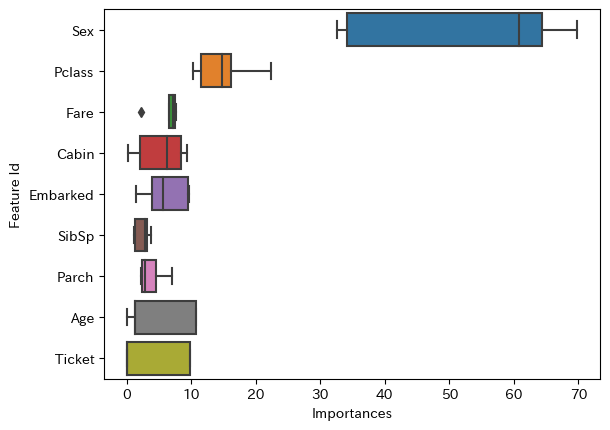

In [12]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.get_feature_importance(prettified=True) for model in models
]

# 特徴量重要度の中央値をとり、sortする
feature_importance_sorted_median = (
    pd.concat(feature_importances)
    .groupby("Feature Id")
    .median()
    .sort_values(by="Importances", ascending=False)
)

# 表示する順番を指定、特徴量重要度の中央値が大きい順に並ぶよう計算
order = feature_importance_sorted_median.index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(
    data=pd.concat(feature_importances),
    x="Importances",
    y="Feature Id",
    orient="h",
    order=order,
)

In [13]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict_proba(test[use_col])[:, 1] for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

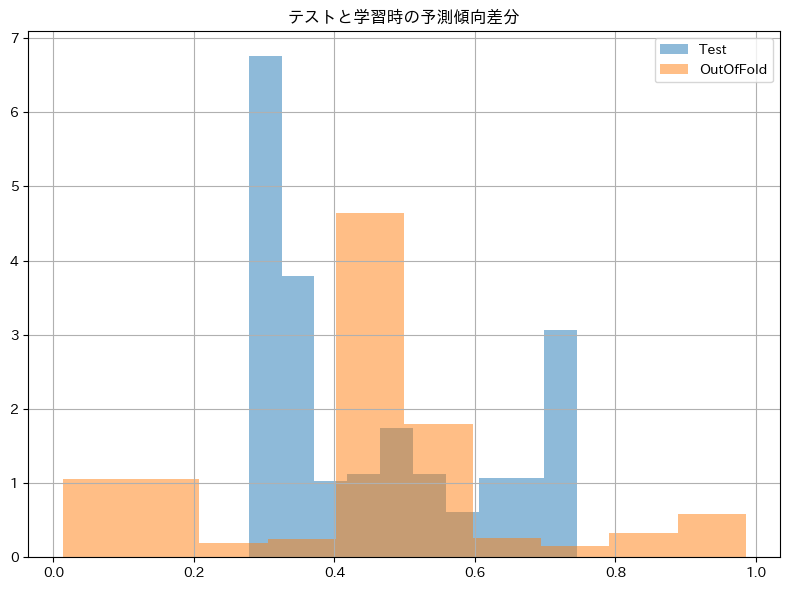

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [15]:
sample_submission["Survived"] = (pred > 0.5).astype(int)
sample_submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [16]:
sample_submission.to_csv(f"../sub/{NOTEBOOK_NAME}_{oof_score:.4f}.csv", index=False)